# Working with the MaiCuBeDa database
https://heidata.uni-heidelberg.de/dataset.xhtml?persistentId=doi:10.11588/data/QSNIQ2&version=1.0

- Holds W3C annotations of renderings of 3D models of cuneiform tablets extracted from HeiCuBeDa, including cropped images representing areas per annotation
- The database creators used only those transliterations for sourcing they deemed reliable as and that were present in the renderings, rather than reconstructed from existing context
- The annotation process underwent multiple different consistency tests

## Structure:
Two different source folders, one “Mixed”, the other “MSII” and each source contains subfolders:
- char
- charannotations
- croppoly_char
- croppoly_wedge
- line
- lineannotations
- wedge
- word
- wordannotations

| ID | Filename | CDLI_Number | IRI | HeidIcon | Time_period | Language | side | bbox | column | line | charindex | charname | transliteration |
|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|
| ... | ... | ... | ... | ... | ... | ... | ... | ... | ... | ... | ... | ... | ... |

Important here are
| Filename | ... | transliteration |
|-------|-------|-------|
| 1_3(disz)_1_1_1_2_HS_1137_06_back.jpg | ... | 1/3(disz) |

(TRANS/)_TRANSLITERATION_UNKNOWN_COLUMN_LINE_CHARINDEX_TABLETNAME_SURFACE

Problem: some rows in column “transliteration” contained delimiter “;” between transliteration signs —> inconsistent columns when creating dataframe
- had to open CSV file in excel to insert  “transliteration_2” which automatically
	adds “;” at end of normal rows but groups those with false delimiter in new col
- File now parseable
- Added HeidIcon as Column name for proper indexing

The images in folder char are named in this schema:
| TRANSLITERATION_COLUMN_LINE_CHARINDEX_TABLETNAME_SURFACE |
|-------|
|  1_3(disz)_1_1_2_HS_1137_06_back.png |

Note that the transliteration 1/3(disz) is part of the image name but uses the seperator "_" instead of "/"
and that the names 

In [1]:
import os
# describe the structure of project folders:

parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
image_folder = os.path.join(parent_dir, "Cuneiform Tests", "MaiCuBeDa", "MaiCuBeDa_Annotations_MSII","char")

print(image_folder)

/Users/Uni/Documents/Uni/Thesis/Cuneiform Tests/MaiCuBeDa/MaiCuBeDa_Annotations_MSII/char


#### Dataframe Creation - Markdown
(And removing whitespace from col names)

In [2]:
import numpy as np 
import pandas as pd

metadata_path = os.path.join(parent_dir, "Cuneiform Tests", "MaiCuBeDa", "dataverse_files", "translitmetadata(in).csv")

csv = pd.read_csv(metadata_path, sep=";", encoding="utf-8")
df_metadata = pd.DataFrame(csv)
# from columns, remove whitespaces
df_metadata.columns = df_metadata.columns.str.strip()

df_metadata.head(1)

,ID,Filename,CDLI_Number,IRI,HeidIcon,Time_period,Language,Genre,side,bbox,column,line,charindex,charname,transliteration,transliteration_2
0,HS_1137_06,1_3(disz)_1_1_1_2_HS_1137_06_back.jpg,P134449,http://cdli.ucla.edu/P134449_back_char_1_2,https://heidicon.ub.uni-heidelberg.de/iiif/2/1...,Ur III (ca. 2100-2000 BC),Sumerian,Administrative,back,"[155, 279, 23, 111]",-1,1,2,SZUSZANA_(13) ...,1/3(disz),NaN


#### Fixing Dataframe indexing
after adding column "transliteration_2" for consistent col count, appending its content to "transliteration" and dropping it


In [3]:
# count all entries of "transliteration_2" that are not empty
count = df_metadata["transliteration_2"].count()

# for each row check if column "translatitertion_2" is empty,
# otherwise, append string-content of column to "translatitertion"
test = 0
for index, row in df_metadata.iterrows():
    # remove whitespace at end of transliteration string
    transl = row["transliteration"].strip()
    transl2 = row["transliteration_2"]
    if pd.notnull(transl2):
        # new string is concatenation of transliteration and transliteration_2
        row["transliteration"] = transl + ", " + transl2
        #print(row)
        test += 1
print("Cols with transliteration_2:\t", count, "\n", "Operations performed:\t\t", test, "\n", "Success:\t\t\t", count == test)

if count == test:
    # drop column "transliteration_2"
    df_metadata = df_metadata.drop(columns=["transliteration_2"])

# get the 22077th entry from metadata
df_metadata["transliteration"].loc[22068]


Cols with transliteration_2:	 51 
 Operations performed:		 51 
 Success:			 True


'ARAD2_(ARADKUR), arad2'

#### Dataframe Creation - Images

In [4]:
images = os.listdir(image_folder)
print(len(images))
df_images = pd.DataFrame(images, columns=["filename"])
df_images.head(1)

27698


,filename
0,u3_1_3_1_HS_294_03_front.png


#### Extract corresponding Char literal from image name
Problem: Some numbered cunei chars are given in format numeral_numeral(char) and have to be combined into the fitting description numeral/numeral(char) to match their exact transliteration in metadata.

*e.g. "1/3(asz@c)" in "1_3(asz@c)_1_-1_-1_HS_793_06_back.png"*

In [5]:
# create new column "char" in df_images from filenames
df_images["char"] = df_images["filename"].str.split("_")

size_before = df_images.filename.size

for index, row in df_images.iterrows():
    # if first elem is a number than merge with second elem
    if row["char"][0].isdigit():
        # keep only transliteration (elem 1-2)
        df_images.at[index, "char"] = row["char"][0] + "-" + row["char"][1]
    else:
        df_images.at[index, "char"] = row["char"][0]
    # files not containing a transliteration are not needed:
    if row["char"][0] == "":
        df_images = df_images.drop(index)

size_after = df_images.filename.size
print("No. of removed rows:\t", size_before - size_after)


#df_images.loc[0]
# get the row where filename is "1_3(asz@c)_1_-1_-1_HS_793_06_back.png" --> df_image.loc[5178]

No. of removed rows:	 39


In [6]:
# save dataframe to csv if not yet existing
df_images.to_csv("df_images.csv", sep=";", encoding="utf-8")

# count cols
count = df_images["char"].count()
print("No. of rows with 'char':\t", count)

No. of rows with 'char':	 27659


In [7]:
'''
# count all images in df_images
imgset_before = df_images["char"]

# for each image in df_images, copy image to imgset folder and rename it to corresponding char
for index, row in df_images.iterrows():
    filename = row["filename"]
    char = row["char"]
    img_path = os.path.join(image_folder, filename)
    img_new_path = os.path.join(imgset_path, char + ".png")
    # if image has transparent areas, skip
    if np.array_equal(np.array([0, 0, 0, 0]), np.array([0, 0, 0, 0])):
        continue
    # copy image to new folder
    os.system("cp " + img_path + " " + img_new_path)



# count all images in imgset folder
imgset_after = os.listdir(imgset_path)
print("No. of removed images:\t", len(imgset_before) - len(imgset_after))

'''

'\n# count all images in df_images\nimgset_before = df_images["char"]\n\n# for each image in df_images, copy image to imgset folder and rename it to corresponding char\nfor index, row in df_images.iterrows():\n    filename = row["filename"]\n    char = row["char"]\n    img_path = os.path.join(image_folder, filename)\n    img_new_path = os.path.join(imgset_path, char + ".png")\n    # if image has transparent areas, skip\n    if np.array_equal(np.array([0, 0, 0, 0]), np.array([0, 0, 0, 0])):\n        continue\n    # copy image to new folder\n    os.system("cp " + img_path + " " + img_new_path)\n\n\n\n# count all images in imgset folder\nimgset_after = os.listdir(imgset_path)\nprint("No. of removed images:\t", len(imgset_before) - len(imgset_after))\n\n'

#### Get number of unique chars to define output classes

In [8]:
# number of unique characters in df_images['char']
unique_chars = df_images["char"].nunique()
print(unique_chars)

907


## Train CNN

In [9]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten
from keras.preprocessing.image import load_img, img_to_array
from sklearn.preprocessing import LabelEncoder
import numpy as np
from tensorflow.keras.models import Sequential

import gc

# run gc.collect() to free up memory
gc.collect()

image_size = 50

# Load the images
images = np.array([img_to_array(load_img(image_folder+"/"+img_path, target_size=(image_size, image_size), color_mode='grayscale')) for img_path in df_images.iloc[:, 0]])

# Reshape the images
images = images.reshape(-1, image_size, image_size, 1)

# Create a Sequential model
model = Sequential()

# Add a Conv2D layer with 32 filters, a 3x3 kernel, and 'relu' activation function
model.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=(image_size, image_size, 1)))

# Add another Conv2D layer with 64 filters and a 3x3 kernel
model.add(Conv2D(64, kernel_size=3, activation='relu'))

# Flatten the tensor output from the previous layer
model.add(Flatten())

# Add a Dense layer with 128 units and 'relu' activation function
model.add(Dense(1500, activation='relu'))

# Add an output Dense layer with 918 units (for all unique labels)
# softmax activation function is used for multi-class classification
model.add(Dense(unique_chars, activation='softmax'))

# Compile the model
# sparse_categorical_crossentropy --> classes > 2
# "adam" optimizer --> the best learning rate or 'sgd' (stoch. gradient descent)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Convert char-labels to integers for training
le = LabelEncoder()
labels = le.fit_transform(df_images.iloc[:, 1])

/Library/Python/3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
# use StratifiedShuffleSplit to split the data into training and testing sets
from sklearn.model_selection import StratifiedShuffleSplit

# Split the data into training and testing sets
sss = StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=0)

# Get the training and testing indices
train_index, test_index = next(sss.split(images, labels))

ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

In [ ]:
# Train the model
#model.fit(images, labels, validation_split=0.2, epochs=10, shuffle=True)

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10)

Epoch 1/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 982s 1s/step - accuracy: 0.1070 - loss: 99.2691 - val_accuracy: 0.2072 - val_loss: 4.4733
Epoch 2/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 829s 1s/step - accuracy: 0.3362 - loss: 3.4787 - val_accuracy: 0.2545 - val_loss: 4.3176
Epoch 3/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 582s 841ms/step - accuracy: 0.6504 - loss: 1.6919 - val_accuracy: 0.2402 - val_loss: 5.6107
Epoch 4/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 632s 914ms/step - accuracy: 0.9046 - loss: 0.4532 - val_accuracy: 0.2157 - val_loss: 6.2976
Epoch 5/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 8008s 12s/step - accuracy: 0.9754 - loss: 0.1156 - val_accuracy: 0.2223 - val_loss: 7.1869
Epoch 6/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 568s 820ms/step - accuracy: 0.9906 - loss: 0.0477 - val_accuracy: 0.2090 - val_loss: 8.1324
Epoch 7/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 552s 797ms/step - accuracy: 0.9903 - loss: 0.0549 - val_accuracy: 0.2171 - val_loss: 10.0520
Epoch 8/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 571s 825ms/step - accuracy: 0.9541 - loss

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 46, 46, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 135424)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1500)           │   203,137,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 907)            │     1,361,407 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 613,553,171 (2.29 GB)

 Trainable params: 204,517,723 (780.17 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 409,035,448 (1.52 GB)

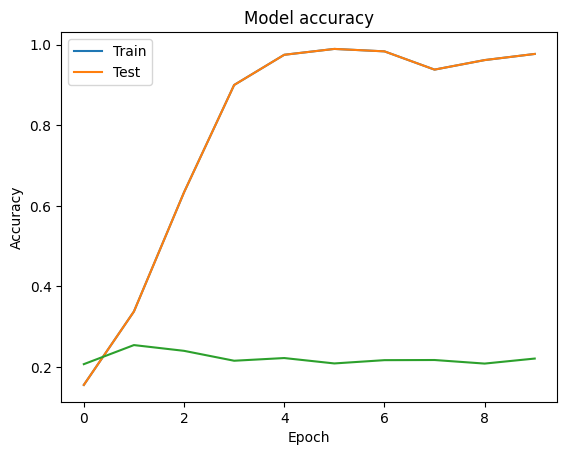

In [ ]:
import os
import matplotlib.pyplot as plt

# plt model acc and loss during training

plt.plot(model.history.history.get('accuracy'))
recall = model.history.history.get('recall')
precision = model.history.history.get('precision')
f1_score = model.history.history.get('f1_score')
fbeta_score = model.history.history.get('fbeta_score')
model.summary()
'''
# save model and created plot with timestamp
timestamp = pd.Timestamp.now().strftime("%d.%m.%Y_%H:%M:%S")
model_name = model.name
plt.savefig(model_name+"_"+"model_acc_"+timestamp+".png")
# save model under name "first_model" in directory model_outputs
model.save('model_outputs/first_'+timestamp+".keras")
'''

# Plot training & validation accuracy values
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# save model and created plot with timestamp
model_name = model.name
timestamp = pd.Timestamp.now().strftime("%d.%m.%Y_%H:%M:%S")
model.save('model_outputs/first_'+timestamp+".keras")
plt.savefig('model_outputs/first_'+timestamp+"_model_acc.png")

# Plot training & validation accuracy values
model_history = pd.DataFrame(model.history.history)
model_history.to_csv('model_outputs/first_'+timestamp+"_history.csv", index=False)

In [ ]:
from matplotlib import pyplot as plt
import cv2

test = df_images["filename"].loc[5]
img = cv2.imread(os.path.join(folder_path, test))
plt.imshow(img)


NameError: name 'folder_path' is not defined